# Detecting BDM In Superbowl Commercials

In [635]:
import pandas as pd
import os
from dotenv import load_dotenv
load_dotenv()

True

In [636]:
BDM_excel = pd.read_excel(f'{os.getenv("BDM_EXCEL_FILE")}')
final_excel = pd.read_excel(f'{os.getenv("FINAL_EXCEL_FILE")}')

In [637]:
final_excel = final_excel.merge(
    BDM_excel[['AdNumber', 'BDM']], 
    on='AdNumber', 
    how='left',
    suffixes=('_old', '')
).drop('BDM_old', axis=1, errors='ignore')


# print number of rows where BDM is NaN, 0 and 1
print(f"Number of rows where BDM is NaN: {final_excel[final_excel['BDM'].isna()].shape[0]}")
print(f"Number of rows where BDM is 0: {final_excel[final_excel['BDM'] == 0].shape[0]}")
print(f"Number of rows where BDM is 1: {final_excel[final_excel['BDM'] == 1].shape[0]}")


Number of rows where BDM is NaN: 22
Number of rows where BDM is 0: 411
Number of rows where BDM is 1: 139


In [638]:
ad_df = final_excel.groupby(['cont_primary_product_type', 'BRAND', 'AdNumber', "BDM"]).size().reset_index(name='count')
ad_df.rename(columns={'cont_primary_product_type': 'product_category', 'BRAND': 'brand', 'AdNumber': 'commercial_number'}, inplace=True)
ad_df.drop(columns=['count'], inplace=True)
ad_df.head(10)

,product_category,brand,commercial_number,BDM
0,1.0,AvocadosfromMexico,AD0357,0.0
1,1.0,AvocadosfromMexico,AD0414,1.0
2,1.0,AvocadosfromMexico,AD0474,0.0
3,1.0,AvocadosfromMexico,AD0525,1.0
4,1.0,AvocadosfromMexico,AD0584,1.0
5,1.0,AvocadosfromMexico,AD0635,1.0
6,1.0,AvocadosfromMexico,AD0745,0.0
7,1.0,BUBLY,AD0586,1.0
8,1.0,Bai,AD0475,0.0
9,1.0,Butterfinger,AD0420,1.0


## Retrieving Transcript

In [639]:
import glob
from pathlib import Path

# Get all txt files recursively from ADS_DIR
ads_dir = Path(os.getenv("ADS_DIR"))
transcript_files = glob.glob(str(ads_dir / "**/*.txt"), recursive=True)
# print transcript_files
print(transcript_files)
# Create a dictionary mapping commercial numbers to file paths
transcript_map = {Path(f).stem: f for f in transcript_files}

# Update transcripts in dataframe
ad_df['transcript'] = ''
for idx, row in ad_df.iterrows():
    commercial_num = row['commercial_number']
    if commercial_num in transcript_map:
        try:
            with open(transcript_map[commercial_num], 'r', encoding='utf-8') as f:
                ad_df.at[idx, 'transcript'] = f.read().strip()
        except FileNotFoundError:
            ad_df.at[idx, 'transcript'] = None
    else:
        ad_df.at[idx, 'transcript'] = None

ad_df[ad_df['transcript'].notna()]
ad_df.head(10)

['/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/ADs/ADs_IG_2015/AD0380.txt', '/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/ADs/ADs_IG_2015/AD0408.txt', '/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/ADs/ADs_IG_2015/AD0399.txt', '/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/ADs/ADs_IG_2015/AD0359.txt', '/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/ADs/ADs_IG_2015/AD0383.txt', '/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/ADs/ADs_IG_2015/AD0393.txt', '/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/ADs/ADs_IG_2015/AD0370.txt', '/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/ADs/ADs_IG_2015/AD0377.txt', '/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/ADs/ADs_IG_2015/AD0404.txt', '/home/arkastor/Development/Commerci

,product_category,brand,commercial_number,BDM,transcript
0,1.0,AvocadosfromMexico,AD0357,0.0,"With the next pick in the first draft ever, Au..."
1,1.0,AvocadosfromMexico,AD0414,1.0,Over here we have the cube of Rubik. This simp...
2,1.0,AvocadosfromMexico,AD0474,0.0,"Guys, how can we be a secret society if we can..."
3,1.0,AvocadosfromMexico,AD0525,1.0,"Well, we did it. We sealed the bad out and kep..."
4,1.0,AvocadosfromMexico,AD0584,1.0,"Pageantry, poise, welcome to the dog show wher..."
5,1.0,AvocadosfromMexico,AD0635,1.0,Welcome to the Avocados from Mexico shopping n...
6,1.0,AvocadosfromMexico,AD0745,0.0,This is officially the worst tailgate I've eve...
7,1.0,BUBLY,AD0586,1.0,"Ooh, Blackberry Bublé, my favorite. You mean B..."
8,1.0,Bai,AD0475,0.0,I don't want to make it tough. I just want to ...
9,1.0,Butterfinger,AD0420,1.0,"A bull rider is bold. Now, a bull rider on a p..."


## Adding OCR Text

In [640]:

ocr_to_merge = pd.read_csv("./ocr_to_merge.csv")
ad_df = ad_df.merge(ocr_to_merge, left_on='commercial_number', right_on='ad', how='left')
ad_df.drop(columns=['ad', 'recognized_text'], inplace=True)
ad_df.rename(columns={'cleaned_text': 'ocr_text'}, inplace=True)

# merge ocr_text with transcript
# TODO: Rename transcript to transcript_plus_ocr
ad_df['transcript'] = ad_df['ocr_text'] + ' ' + ad_df['transcript']
ad_df.drop(columns=['ocr_text'], inplace=True)

ad_df.head()


,product_category,brand,commercial_number,BDM,transcript
0,1.0,AvocadosfromMexico,AD0357,0.0,FIRST DRAFT EVER DRAFT SLOTH DODO BIRD FIRE PO...
1,1.0,AvocadosfromMexico,AD0414,1.0,I Avocados Mexico ALWAYS IN SEASON Over here w...
2,1.0,AvocadosfromMexico,AD0474,0.0,"HEALTHY Avocados Mexico ALWAYS IN SEASON Guys,..."
3,1.0,AvocadosfromMexico,AD0525,1.0,Chris Meet Cl Won Meet Avocados Mexico ALWAYS ...
4,1.0,AvocadosfromMexico,AD0584,1.0,Canine Avocados From Mexico OS Me dos From Avo...


In [641]:
!python -m spacy download en_core_web_sm


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 10.8 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# Determining Frequency of Superlatives and Comparative Adjectives

In [642]:
import spacy
import pandas as pd
from collections import Counter

# Load English language model
nlp = spacy.load('en_core_web_sm')

# Keywords that indicate uniqueness or superiority (expanded list)
uniqueness_terms = {
    'unique', 'exclusive', 'only', 'revolutionary', 'innovative', 'leading',
    'first', 'best-in-class', 'superior', 'advanced', 'breakthrough',
    'ultimate', 'premium', 'finest', 'exceptional', 'unmatched',
    'unrivaled', 'outstanding', 'extraordinary', 'remarkable', 'unparalleled',
    'pioneering', 'cutting-edge', 'state-of-the-art', 'next-generation', 'compared', 'original', 'legacy'
}

# Initialize lists to store percentages and words
analysis_results = []
identified_words = []

# Process each transcript
for transcript in ad_df['transcript']:
    # Initialize counters and word lists
    word_count = 0
    metrics = Counter()
    words = {
        'comparatives': [],
        'superlatives': [],
        'unique_words': [],
        'bdm_words': []
    }
    
    # Process the text with spaCy
    doc = nlp(str(transcript))
    
    # Analyze each token
    for token in doc:
        if token.is_alpha:  # Only count actual words
            word_count += 1
            
            if token.tag_ == 'JJR':
                metrics['comparative'] += 1
                words['comparatives'].append(token.text)
                words['bdm_words'].append(token.text)
            elif token.tag_ == 'JJS':
                metrics['superlative'] += 1
                words['superlatives'].append(token.text)
                words['bdm_words'].append(token.text)
            elif token.text.lower() in uniqueness_terms:
                metrics['uniqueness'] += 1
                words['unique_words'].append(token.text)
                words['bdm_words'].append(token.text)
    # Calculate percentages
    if word_count > 0:
        percentages = {
            'comparative_pct': (metrics['comparative'] / word_count) * 100,
            'superlative_pct': (metrics['superlative'] / word_count) * 100,
            'uniqueness_pct': (metrics['uniqueness'] / word_count) * 100,
            'total_bdm_terms_pct': sum(metrics.values()) / word_count * 100
        }
    else:
        percentages = {
            'comparative_pct': 0,
            'superlative_pct': 0,
            'uniqueness_pct': 0,
            'total_bdm_terms_pct': 0
        }
    
    analysis_results.append(percentages)
    identified_words.append(words)

# Add results to DataFrame
results_df = pd.DataFrame(analysis_results)
words_df = pd.DataFrame(identified_words)

# Combine all DataFrames
ad_df = pd.concat([
    ad_df, 
    results_df,
    words_df
], axis=1)

# Show summary statistics
print("\nPercentage Statistics:")
print(results_df.describe())

# Show correlation with BDM
print("\nCorrelation with BDM:")
for col in results_df.columns:
    correlation = ad_df[col].corr(ad_df['BDM'])
    print(f"{col}: {correlation:.3f}")
# sort by highest amount of superlatives, then by highest amount of comparatives
ad_df = ad_df.sort_values(by=['superlative_pct', 'comparative_pct', 'uniqueness_pct'], ascending=[False, False, False])
ad_df.head(10)


Percentage Statistics:
       comparative_pct  superlative_pct  uniqueness_pct  total_bdm_terms_pct
count       550.000000       550.000000      550.000000           550.000000
mean          0.358621         0.142668        0.358291             0.859580
std           0.927408         0.450400        1.000380             1.463478
min           0.000000         0.000000        0.000000             0.000000
25%           0.000000         0.000000        0.000000             0.000000
50%           0.000000         0.000000        0.000000             0.000000
75%           0.000000         0.000000        0.000000             1.287834
max           9.259259         4.210526        9.090909            10.714286

Correlation with BDM:
comparative_pct: 0.097
superlative_pct: 0.068
uniqueness_pct: 0.032
total_bdm_terms_pct: 0.104


,product_category,brand,commercial_number,BDM,transcript,comparative_pct,superlative_pct,uniqueness_pct,total_bdm_terms_pct,comparatives,superlatives,unique_words,bdm_words
393,19.0,LittleCaesars,AD0654,1.0,Delivery available from locations with online ...,0.000000,4.210526,1.052632,5.263158,[],"[best, best, Best, best]",[only],"[only, best, best, Best, best]"
275,6.0,PersilProclean,AD0612,1.0,STAIN LAB WATER V I IN Original ITS MORE THAN ...,3.571429,3.571429,3.571429,10.714286,"[MORE, deeper]","[deepest, deepest]","[Original, exceptional]","[Original, MORE, deepest, deeper, exceptional,..."
40,1.0,Fiji,AD0482,0.0,EARTHS FINEST WATER EARTHS FINEST WATER FIJI W...,0.000000,2.702703,5.405405,8.108108,[],[finest],"[FINEST, FINEST]","[FINEST, FINEST, finest]"
344,12.0,DisneyPlus,AD0758,0.0,LORI Disney Plus has the greatest movies and s...,0.000000,2.500000,1.250000,3.750000,[],"[greatest, greatest]",[only],"[greatest, greatest, only]"
414,20.0,ETRADE,AD0701,0.0,ft THIS MIGHT BE THE YEAR YOU FINALLY GET IN S...,0.000000,2.500000,0.000000,2.500000,[],[best],[],[best]
454,21.0,Sprint,AD0617,1.0,Compared Verizon Go Unlimited and Subject cred...,1.418440,2.127660,4.255319,7.801418,"[More, more]","[best, best, best]","[Compared, Compared, Advanced, compared, compa...","[Compared, Compared, Advanced, compared, compa..."
118,2.0,Budweiser,AD0257,0.0,BLACK U Buck St Louis MO NEW BLACK CROWN BLACK...,0.000000,2.000000,0.000000,2.000000,[],[finest],[],[finest]
201,4.0,Jeep,AD0541,0.0,Chase l l The New Jeep Cherokee Jeep Jeep a re...,1.886792,1.886792,0.000000,3.773585,[easier],[best],[],"[easier, best]"
540,25.0,TOURISMAUSTRALIA,AD0567,1.0,L M S RESTAURANTS Sponsored Dy Tourism LIKE AU...,0.000000,1.886792,0.000000,1.886792,[],"[finest, best, best]",[],"[finest, best, best]"
493,22.0,TurkishAirlines,AD0684,1.0,YET TODAY OVER MILLION AMERICANS STEPPED ABROA...,0.000000,1.754386,1.754386,3.508772,[],[Most],[FIRST],"[FIRST, Most]"


In [643]:
# remove superlatives, comparatives and unique_words from ad_df
# TODO: Comment back in
# ad_df.drop(columns=['superlatives', 'comparatives', 'unique_words', 'bdm_words'], inplace=True)
ad_df.drop(columns=['comparative_pct', 'superlative_pct', 'uniqueness_pct'], inplace=True)
ad_df.head(10)


,product_category,brand,commercial_number,BDM,transcript,total_bdm_terms_pct,comparatives,superlatives,unique_words,bdm_words
393,19.0,LittleCaesars,AD0654,1.0,Delivery available from locations with online ...,5.263158,[],"[best, best, Best, best]",[only],"[only, best, best, Best, best]"
275,6.0,PersilProclean,AD0612,1.0,STAIN LAB WATER V I IN Original ITS MORE THAN ...,10.714286,"[MORE, deeper]","[deepest, deepest]","[Original, exceptional]","[Original, MORE, deepest, deeper, exceptional,..."
40,1.0,Fiji,AD0482,0.0,EARTHS FINEST WATER EARTHS FINEST WATER FIJI W...,8.108108,[],[finest],"[FINEST, FINEST]","[FINEST, FINEST, finest]"
344,12.0,DisneyPlus,AD0758,0.0,LORI Disney Plus has the greatest movies and s...,3.750000,[],"[greatest, greatest]",[only],"[greatest, greatest, only]"
414,20.0,ETRADE,AD0701,0.0,ft THIS MIGHT BE THE YEAR YOU FINALLY GET IN S...,2.500000,[],[best],[],[best]
454,21.0,Sprint,AD0617,1.0,Compared Verizon Go Unlimited and Subject cred...,7.801418,"[More, more]","[best, best, best]","[Compared, Compared, Advanced, compared, compa...","[Compared, Compared, Advanced, compared, compa..."
118,2.0,Budweiser,AD0257,0.0,BLACK U Buck St Louis MO NEW BLACK CROWN BLACK...,2.000000,[],[finest],[],[finest]
201,4.0,Jeep,AD0541,0.0,Chase l l The New Jeep Cherokee Jeep Jeep a re...,3.773585,[easier],[best],[],"[easier, best]"
540,25.0,TOURISMAUSTRALIA,AD0567,1.0,L M S RESTAURANTS Sponsored Dy Tourism LIKE AU...,1.886792,[],"[finest, best, best]",[],"[finest, best, best]"
493,22.0,TurkishAirlines,AD0684,1.0,YET TODAY OVER MILLION AMERICANS STEPPED ABROA...,3.508772,[],[Most],[FIRST],"[FIRST, Most]"


# Product Category DF

In [644]:

product_brands_df = pd.read_csv("product_categories.csv")
product_brands_df.head(40)
product_brands_df = product_brands_df.drop('product_cat_id', axis=1)
ad_df = ad_df.drop('product_category', axis=1)
display(product_brands_df)
display(ad_df)

,product_cat_name,product_cat_keywords,product_cat_brands
0,Alcoholic beverages (Beer Hard Seltzer),"['smooth', 'rich', 'refreshing', 'aromatic', '...","['Anheuser Busch InBev', 'Becks Beer', 'Bud Li..."
1,Banking & Investments,"['secure', 'reliable', 'customized', 'personal...","['BankofAmerica', 'Coinbase', 'Cryptocom', 'Di..."
2,Car Accessories & Related Services,"['safe', 'protect', 'protected', 'protection',...","['Michelin', 'Wallbox', 'Weathertech']"
3,Car Manufacturer,"['Luxurious', 'Efficient', 'Powerful', 'Innova...","['Acura', 'AlfaRomeo', 'Audi', 'BMW', 'Buick',..."
4,Car Sales & Services Platform,"['easy', 'perfect', 'love', 'expert', 'really'...","['Carvana', 'Vroom', 'Carscom', 'Carmax']"
5,"Clothing, shoes and apparel","['favorite', 'designed', 'comfortable', 'uncom...","['CalvinKlein', 'Gildan', 'HANDM', 'Marmot', '..."
6,Consumer Electronics and Appliances,"['Smart', 'Display', 'Control', 'Touchscreen',...","['BlackBerry', 'Google', 'Intel', 'LGEEAudioVi..."
7,Cosmetics and personal care products,"['luxurious', 'nourishing', 'radiant', 'smooth...","['Fitbit', 'PlanetFitness']"
8,Diet and exercise products,"['healthy', 'energizing', 'effective', 'smart'...","['CalvinKlein', 'Gildan', 'Marmot', 'Skechers'..."
9,Food Delivery Services,"['easy', 'delivered', 'local', 'convenience', ...","['DoorDash', 'UberEats']"


,brand,commercial_number,BDM,transcript,total_bdm_terms_pct,comparatives,superlatives,unique_words,bdm_words
393,LittleCaesars,AD0654,1.0,Delivery available from locations with online ...,5.263158,[],"[best, best, Best, best]",[only],"[only, best, best, Best, best]"
275,PersilProclean,AD0612,1.0,STAIN LAB WATER V I IN Original ITS MORE THAN ...,10.714286,"[MORE, deeper]","[deepest, deepest]","[Original, exceptional]","[Original, MORE, deepest, deeper, exceptional,..."
40,Fiji,AD0482,0.0,EARTHS FINEST WATER EARTHS FINEST WATER FIJI W...,8.108108,[],[finest],"[FINEST, FINEST]","[FINEST, FINEST, finest]"
344,DisneyPlus,AD0758,0.0,LORI Disney Plus has the greatest movies and s...,3.750000,[],"[greatest, greatest]",[only],"[greatest, greatest, only]"
414,ETRADE,AD0701,0.0,ft THIS MIGHT BE THE YEAR YOU FINALLY GET IN S...,2.500000,[],[best],[],[best]
...,...,...,...,...,...,...,...,...,...
534,Squarespace,AD0455,1.0,REAL REAL TALK Real TALK TALK Real REAL TALK F...,0.000000,[],[],[],[]
535,Squarespace,AD0508,0.0,G ET U R D O MA N B E F 0 RE 6 0 N E MAKE YOUR...,0.000000,[],[],[],[]
537,Squarespace,AD0675,0.0,Welcome MINNESOTA Est To A website makes it re...,0.000000,[],[],[],[]
538,Squarespace,AD0730,0.0,1 1 7 6 delete Job caps MOVE HOME ANEW TAKE ON...,0.000000,[],[],[],[]


In [645]:
# Create a dictionary to map brands to their product categories and other attributes
brand_to_info = {}
for _, row in product_brands_df.iterrows():
    # Convert string representation of list to actual list
    brands = eval(row['product_cat_brands'])
    for brand in brands:
        # Remove spaces and convert to lowercase for more robust matching
        brand = brand.replace(' ', '').lower()
        # Store all columns for this brand
        brand_to_info[brand] = {col: row[col] for col in product_brands_df.columns}

# Function to find category info for a brand
def find_brand_info(brand):
    # Clean brand name for matching
    clean_brand = brand.replace(' ', '').lower()
    return brand_to_info.get(clean_brand)

# Add all product category columns to ad_df
for col in product_brands_df.columns:
    ad_df[col] = ad_df['brand'].apply(lambda x: find_brand_info(x)[col] if find_brand_info(x) else None)

# Print brands that couldn't be mapped
unmapped_brands = ad_df[ad_df['product_cat_name'].isna()]['brand'].unique()
if len(unmapped_brands) > 0:
    print("Brands without category mapping:")
    for brand in unmapped_brands:
        print(f"- {brand}")

# Print number of rows with missing category
print(f"Number of rows where product category is NaN: {ad_df[ad_df['product_cat_name'].isna()].shape[0]}")

# Drop rows with missing categories
ad_df = ad_df.dropna(subset=['product_cat_name'])

print(f"Final number of rows with missing categories: {ad_df[ad_df['product_cat_name'].isna()].shape[0]}")

Brands without category mapping:
- AvocadosfromMexico
- Beck's Beer
- Volkswagen
- THEWASHINGTONPOST
- BassProShops
- Colgate
- DoveMenCare
- Schick
- Century21
- Hyndai
- IrishSpring
- Groupon
- DrSquatch
- CaesarsSportsbook
- LGCEAudioVisual
- Always
- Axe
- DollarShaveClub
- Gillette
- Huggies
- Itsa10Haircare
- Olay
- Weightwatchers
- UNIVERSALPARKSANDRESORTS
- Mercari
- Fiverr
- Indeed
Number of rows where product category is NaN: 38
Final number of rows with missing categories: 0


In [646]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from collections import defaultdict

nltk.download('all')


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /home/arkastor/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/arkastor/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /home/arkastor/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /home/arkastor/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /home/arkastor/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]  

True

In [647]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Initialize the sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')
def get_semantic_similarity(text, keywords):
    # Convert string keywords list to actual list if needed
    if isinstance(keywords, str):
        keywords = eval(keywords)
    
    # Combine keywords into a single string
    keywords_text = ' '.join(keywords)
    
    # Get embeddings
    text_embedding = model.encode([str(text)])[0]
    keywords_embedding = model.encode([keywords_text])[0]
    
    # Calculate cosine similarity
    similarity = np.dot(text_embedding, keywords_embedding) / (
        np.linalg.norm(text_embedding) * np.linalg.norm(keywords_embedding)
    )
    
    # Find most similar phrases
    sentences = str(text).split('.')
    sentence_embeddings = model.encode(sentences)
    keyword_embedding = model.encode([keywords_text])[0]
    
    # Calculate similarities for each sentence
    sentence_similarities = np.dot(sentence_embeddings, keyword_embedding) / (
        np.linalg.norm(sentence_embeddings, axis=1) * 
        np.linalg.norm(keyword_embedding)
    )
    
    # Get top 3 most similar sentences
    top_indices = np.argsort(sentence_similarities)[-3:][::-1]
    similar_phrases = [sentences[i].strip() for i in top_indices if sentence_similarities[i] > 0.3]
    
    return similarity, similar_phrases

# Apply the analysis to the DataFrame
similarities = []
similar_phrases = []

for _, row in ad_df.iterrows():
    sim, phrases = get_semantic_similarity(row['transcript'], row['product_cat_keywords'])
    similarities.append(sim)
    similar_phrases.append(phrases)

# Add new columns to DataFrame
ad_df['keyword_similarity'] = similarities
ad_df['similar_phrases'] = similar_phrases


ad_df.head(10)

,brand,commercial_number,BDM,transcript,total_bdm_terms_pct,comparatives,superlatives,unique_words,bdm_words,product_cat_name,product_cat_keywords,product_cat_brands,keyword_similarity,similar_phrases
393,LittleCaesars,AD0654,1.0,Delivery available from locations with online ...,5.263158,[],"[best, best, Best, best]",[only],"[only, best, best, Best, best]",Quick Service Restaurants & Food Chains,"['fresh', 'enjoy', 'organic', 'natural', 'deli...","['BurgerKing', 'Chipotle', 'HardRock', 'JimmyJ...",0.223981,[]
275,PersilProclean,AD0612,1.0,STAIN LAB WATER V I IN Original ITS MORE THAN ...,10.714286,"[MORE, deeper]","[deepest, deepest]","[Original, exceptional]","[Original, MORE, deepest, deeper, exceptional,...",Household and lawn and garden supplies,"['powerful', 'effective', 'reliable', 'fast-ac...","['Febreze', 'Loctite', 'MrClean', 'PersilProCl...",0.370549,"[Purcell Pro Clean, STAIN LAB WATER V I IN Ori..."
40,Fiji,AD0482,0.0,EARTHS FINEST WATER EARTHS FINEST WATER FIJI W...,8.108108,[],[finest],"[FINEST, FINEST]","[FINEST, FINEST, finest]","Non-Softdrinks (Water, Milk, Milk Substitutes)","['pure', 'refreshing', 'natural', 'nature', 's...","['Fiji', 'LifeWTR', 'Oatly', 'GotMilk']",0.292673,[EARTHS FINEST WATER EARTHS FINEST WATER FIJI ...
344,DisneyPlus,AD0758,0.0,LORI Disney Plus has the greatest movies and s...,3.750000,[],"[greatest, greatest]",[only],"[greatest, greatest, only]",Streaming Service,"['innovative', 'seamless', 'immersive', 'exclu...","['AmazonPrimeVideo', 'DisneyPlus', 'Hulu', 'Pa...",0.201168,[]
414,ETRADE,AD0701,0.0,ft THIS MIGHT BE THE YEAR YOU FINALLY GET IN S...,2.500000,[],[best],[],[best],Banking & Investments,"['secure', 'reliable', 'customized', 'personal...","['BankofAmerica', 'Coinbase', 'Cryptocom', 'Di...",0.269285,[]
454,Sprint,AD0617,1.0,Compared Verizon Go Unlimited and Subject cred...,7.801418,"[More, more]","[best, best, best]","[Compared, Compared, Advanced, compared, compa...","[Compared, Compared, Advanced, compared, compa...",Telecommuniactions services,"['5G', 'LTE', 'network', 'sound', 'unlimited',...","['Mint', 'Sprint', 'TMobile', 'VerizonWireless']",0.423689,[And a bird horse! Why don't you just tell peo...
118,Budweiser,AD0257,0.0,BLACK U Buck St Louis MO NEW BLACK CROWN BLACK...,2.000000,[],[finest],[],[finest],Alcoholic beverages (Beer Hard Seltzer),"['smooth', 'rich', 'refreshing', 'aromatic', '...","['Anheuser Busch InBev', 'Becks Beer', 'Bud Li...",0.268675,[]
201,Jeep,AD0541,0.0,Chase l l The New Jeep Cherokee Jeep Jeep a re...,3.773585,[easier],[best],[],"[easier, best]",Car Manufacturer,"['Luxurious', 'Efficient', 'Powerful', 'Innova...","['Acura', 'AlfaRomeo', 'Audi', 'BMW', 'Buick',...",0.343729,[Chase l l The New Jeep Cherokee Jeep Jeep a r...
540,TOURISMAUSTRALIA,AD0567,1.0,L M S RESTAURANTS Sponsored Dy Tourism LIKE AU...,1.886792,[],"[finest, best, best]",[],"[finest, best, best]",Travel and Booking Platforms,"['Discover', 'Widen', 'Feel', 'Connect', 'Go',...","['Airbnb', 'Apartmentscom', 'TOURISMAUSTRALIA'...",0.104097,[]
493,TurkishAirlines,AD0684,1.0,YET TODAY OVER MILLION AMERICANS STEPPED ABROA...,3.508772,[],[Most],[FIRST],"[FIRST, Most]",Travel and Booking Platforms,"['Discover', 'Widen', 'Feel', 'Connect', 'Go',...","['Airbnb', 'Apartmentscom', 'TOURISMAUSTRALIA'...",0.206942,[]


In [648]:
# TODO: Implement proper handling of missing values

ad_df[ad_df.isnull().any(axis=1)].head()
ad_df[ad_df.isna().any(axis=1)].head()

ad_df = ad_df.dropna()
ad_df = ad_df[ad_df['transcript'] != '']
ad_df = ad_df[ad_df['transcript'] != '']

# print all from ad_df with empty values
print(ad_df[ad_df.isnull().any(axis=1)])
print(ad_df[ad_df.isna().any(axis=1)])

Empty DataFrame
Columns: [brand, commercial_number, BDM, transcript, total_bdm_terms_pct, comparatives, superlatives, unique_words, bdm_words, product_cat_name, product_cat_keywords, product_cat_brands, keyword_similarity, similar_phrases]
Index: []
Empty DataFrame
Columns: [brand, commercial_number, BDM, transcript, total_bdm_terms_pct, comparatives, superlatives, unique_words, bdm_words, product_cat_name, product_cat_keywords, product_cat_brands, keyword_similarity, similar_phrases]
Index: []


In [649]:
ad_df.head(20)

,brand,commercial_number,BDM,transcript,total_bdm_terms_pct,comparatives,superlatives,unique_words,bdm_words,product_cat_name,product_cat_keywords,product_cat_brands,keyword_similarity,similar_phrases
393,LittleCaesars,AD0654,1.0,Delivery available from locations with online ...,5.263158,[],"[best, best, Best, best]",[only],"[only, best, best, Best, best]",Quick Service Restaurants & Food Chains,"['fresh', 'enjoy', 'organic', 'natural', 'deli...","['BurgerKing', 'Chipotle', 'HardRock', 'JimmyJ...",0.223981,[]
275,PersilProclean,AD0612,1.0,STAIN LAB WATER V I IN Original ITS MORE THAN ...,10.714286,"[MORE, deeper]","[deepest, deepest]","[Original, exceptional]","[Original, MORE, deepest, deeper, exceptional,...",Household and lawn and garden supplies,"['powerful', 'effective', 'reliable', 'fast-ac...","['Febreze', 'Loctite', 'MrClean', 'PersilProCl...",0.370549,"[Purcell Pro Clean, STAIN LAB WATER V I IN Ori..."
40,Fiji,AD0482,0.0,EARTHS FINEST WATER EARTHS FINEST WATER FIJI W...,8.108108,[],[finest],"[FINEST, FINEST]","[FINEST, FINEST, finest]","Non-Softdrinks (Water, Milk, Milk Substitutes)","['pure', 'refreshing', 'natural', 'nature', 's...","['Fiji', 'LifeWTR', 'Oatly', 'GotMilk']",0.292673,[EARTHS FINEST WATER EARTHS FINEST WATER FIJI ...
344,DisneyPlus,AD0758,0.0,LORI Disney Plus has the greatest movies and s...,3.750000,[],"[greatest, greatest]",[only],"[greatest, greatest, only]",Streaming Service,"['innovative', 'seamless', 'immersive', 'exclu...","['AmazonPrimeVideo', 'DisneyPlus', 'Hulu', 'Pa...",0.201168,[]
414,ETRADE,AD0701,0.0,ft THIS MIGHT BE THE YEAR YOU FINALLY GET IN S...,2.500000,[],[best],[],[best],Banking & Investments,"['secure', 'reliable', 'customized', 'personal...","['BankofAmerica', 'Coinbase', 'Cryptocom', 'Di...",0.269285,[]
454,Sprint,AD0617,1.0,Compared Verizon Go Unlimited and Subject cred...,7.801418,"[More, more]","[best, best, best]","[Compared, Compared, Advanced, compared, compa...","[Compared, Compared, Advanced, compared, compa...",Telecommuniactions services,"['5G', 'LTE', 'network', 'sound', 'unlimited',...","['Mint', 'Sprint', 'TMobile', 'VerizonWireless']",0.423689,[And a bird horse! Why don't you just tell peo...
118,Budweiser,AD0257,0.0,BLACK U Buck St Louis MO NEW BLACK CROWN BLACK...,2.000000,[],[finest],[],[finest],Alcoholic beverages (Beer Hard Seltzer),"['smooth', 'rich', 'refreshing', 'aromatic', '...","['Anheuser Busch InBev', 'Becks Beer', 'Bud Li...",0.268675,[]
201,Jeep,AD0541,0.0,Chase l l The New Jeep Cherokee Jeep Jeep a re...,3.773585,[easier],[best],[],"[easier, best]",Car Manufacturer,"['Luxurious', 'Efficient', 'Powerful', 'Innova...","['Acura', 'AlfaRomeo', 'Audi', 'BMW', 'Buick',...",0.343729,[Chase l l The New Jeep Cherokee Jeep Jeep a r...
540,TOURISMAUSTRALIA,AD0567,1.0,L M S RESTAURANTS Sponsored Dy Tourism LIKE AU...,1.886792,[],"[finest, best, best]",[],"[finest, best, best]",Travel and Booking Platforms,"['Discover', 'Widen', 'Feel', 'Connect', 'Go',...","['Airbnb', 'Apartmentscom', 'TOURISMAUSTRALIA'...",0.104097,[]
493,TurkishAirlines,AD0684,1.0,YET TODAY OVER MILLION AMERICANS STEPPED ABROA...,3.508772,[],[Most],[FIRST],"[FIRST, Most]",Travel and Booking Platforms,"['Discover', 'Widen', 'Feel', 'Connect', 'Go',...","['Airbnb', 'Apartmentscom', 'TOURISMAUSTRALIA'...",0.206942,[]


In [650]:

# show all rows ehere bdm is 1.0 and where industry is product_cat_id 4

nice_df = ad_df[ad_df['BDM'] == 1.0]


# Create a function to find shared words
def get_shared_words(row):
    # Convert keywords string to list if it's a string
    keywords = eval(row['product_cat_keywords']) if isinstance(row['product_cat_keywords'], str) else row['product_cat_keywords']
    
    # Convert all keywords to lowercase for better matching
    keywords = [word.lower() for word in keywords]
    
    # Split transcript into words and convert to lowercase
    transcript_words = set(word.lower() for word in str(row['transcript']).split())
    
    # Find intersection between keywords and transcript words
    shared = [word for word in keywords if word in transcript_words]
    
    return shared

# Add new column for shared words
ad_df['shared_keywords'] = ad_df.apply(get_shared_words, axis=1)

# Add column for count of shared words
ad_df['shared_keywords_count'] = ad_df['shared_keywords'].str.len()

# Update the display code
nice_df = ad_df[ad_df['BDM'] == 1.0]
display(nice_df)

,brand,commercial_number,BDM,transcript,total_bdm_terms_pct,comparatives,superlatives,unique_words,bdm_words,product_cat_name,product_cat_keywords,product_cat_brands,keyword_similarity,similar_phrases,shared_keywords,shared_keywords_count
393,LittleCaesars,AD0654,1.0,Delivery available from locations with online ...,5.263158,[],"[best, best, Best, best]",[only],"[only, best, best, Best, best]",Quick Service Restaurants & Food Chains,"['fresh', 'enjoy', 'organic', 'natural', 'deli...","['BurgerKing', 'Chipotle', 'HardRock', 'JimmyJ...",0.223981,[],[],0
275,PersilProclean,AD0612,1.0,STAIN LAB WATER V I IN Original ITS MORE THAN ...,10.714286,"[MORE, deeper]","[deepest, deepest]","[Original, exceptional]","[Original, MORE, deepest, deeper, exceptional,...",Household and lawn and garden supplies,"['powerful', 'effective', 'reliable', 'fast-ac...","['Febreze', 'Loctite', 'MrClean', 'PersilProCl...",0.370549,"[Purcell Pro Clean, STAIN LAB WATER V I IN Ori...","[clean, stain]",2
454,Sprint,AD0617,1.0,Compared Verizon Go Unlimited and Subject cred...,7.801418,"[More, more]","[best, best, best]","[Compared, Compared, Advanced, compared, compa...","[Compared, Compared, Advanced, compared, compa...",Telecommuniactions services,"['5G', 'LTE', 'network', 'sound', 'unlimited',...","['Mint', 'Sprint', 'TMobile', 'VerizonWireless']",0.423689,[And a bird horse! Why don't you just tell peo...,"[lte, network, unlimited, save, advanced, cove...",6
540,TOURISMAUSTRALIA,AD0567,1.0,L M S RESTAURANTS Sponsored Dy Tourism LIKE AU...,1.886792,[],"[finest, best, best]",[],"[finest, best, best]",Travel and Booking Platforms,"['Discover', 'Widen', 'Feel', 'Connect', 'Go',...","['Airbnb', 'Apartmentscom', 'TOURISMAUSTRALIA'...",0.104097,[],"[unforgettable, trip, deals]",3
493,TurkishAirlines,AD0684,1.0,YET TODAY OVER MILLION AMERICANS STEPPED ABROA...,3.508772,[],[Most],[FIRST],"[FIRST, Most]",Travel and Booking Platforms,"['Discover', 'Widen', 'Feel', 'Connect', 'Go',...","['Airbnb', 'Apartmentscom', 'TOURISMAUSTRALIA'...",0.206942,[],[widen],1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,DraftKings,AD0761,1.0,GAMBLING PROBLEM CALL PA OR TEXT NY PROBLEM CA...,0.000000,[],[],[],[],Nonprofit organizations,"['dedicated', 'compassionate', 'impactful', 'm...","['AmericanPetroleumInstitute', 'DonaldTrumpCam...",0.054898,[],[],0
511,Facebook,AD0644,1.0,TABLE ROCK LAKE Facebook Group ROCKY BALBOA GO...,0.000000,[],[],[],[],Social Media,"['first', 'move', 'power', 'stand out', 'rock'...","['BLACTURE', 'Bumble', 'Facebook']",0.484344,[TABLE ROCK LAKE Facebook Group ROCKY BALBOA G...,"[rock, want]",2
526,MichaelBloombergCampaign,AD0655,1.0,ORA Future Football Den MIKE STARTED A NATIONA...,0.000000,[],[],[],[],Nonprofit organizations,"['dedicated', 'compassionate', 'impactful', 'm...","['AmericanPetroleumInstitute', 'DonaldTrumpCam...",0.125978,[],[],0
530,Rakuten,AD0784,1.0,"0 Cash Wack Get the app Bet to you, madam. Leo...",0.000000,[],[],[],[],Banking & Investments,"['secure', 'reliable', 'customized', 'personal...","['BankofAmerica', 'Coinbase', 'Cryptocom', 'Di...",0.193033,[],"[smart, time]",2


In [651]:
# Calculate the minimum number of samples in each group
# 
min_samples = min(len(ad_df[ad_df['BDM'] == 1]), len(ad_df[ad_df['BDM'] == 0]))

# Perform undersampling
ad_df_balanced = pd.concat([
    ad_df[ad_df['BDM'] == 1].sample(n=min_samples, random_state=42),
    ad_df[ad_df['BDM'] == 0].sample(n=min_samples, random_state=42)
]).reset_index(drop=True)

# Print the results
print(f"Total rows: {len(ad_df_balanced)}")
print(f"Rows with BDM = 1.0: {len(ad_df_balanced[ad_df_balanced['BDM'] == 1.0])}")
print(f"Rows with BDM = 0.0: {len(ad_df_balanced[ad_df_balanced['BDM'] == 0.0])}")



commercial_numbers = ad_df_balanced['commercial_number']
ad_df_balanced = ad_df_balanced[['keyword_similarity', 'total_bdm_terms_pct', 'BDM']]


ad_df_balanced.head(20)

Total rows: 250
Rows with BDM = 1.0: 125
Rows with BDM = 0.0: 125


,keyword_similarity,total_bdm_terms_pct,BDM
0,0.269867,9.259259,1.0
1,0.389010,7.317073,1.0
2,0.342260,1.435407,1.0
3,0.264750,0.000000,1.0
4,0.189980,1.075269,1.0
5,0.265246,0.000000,1.0
6,0.198709,0.819672,1.0
7,0.193033,0.000000,1.0
8,0.176719,0.000000,1.0
9,0.206942,3.508772,1.0


## Ansatz 1 (Machine learning)

In [652]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
# Prepare features
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
from sklearn.metrics import confusion_matrix, roc_curve, auc
# import gridsearchcv
from sklearn.model_selection import GridSearchCV



In [653]:
# Prepare the data
target = ad_df_balanced['BDM']
data = ad_df_balanced.drop(['BDM'], axis=1)

In [654]:
def get_base_models():
    """Return dictionary of base model configurations"""
    return {
        'Majority Classifier': DummyClassifier(),
        'Logistic Regression': LogisticRegression(random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'Support Vector Machine': SVC(random_state=42),
        'K-Nearest Neighbors': KNeighborsClassifier(),
        'AdaBoost': AdaBoostClassifier(random_state=42),
    }

In [655]:



from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

def get_param_distributions():
    """Return parameter distributions for RandomizedSearchCV"""
    return {
        'Logistic Regression': {
            'C': uniform(0.1, 10.0),
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear']
        },
        'Decision Tree': {
            'max_depth': randint(3, 10),
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 10)
        },
        'Random Forest': {
            'n_estimators': randint(50, 300),
            'max_depth': randint(3, 10),
            'min_samples_split': randint(2, 20)
        },
        'Support Vector Machine': {
            'C': uniform(0.1, 20.0),
            'kernel': ['rbf', 'linear']
        },
        'Gradient Boosting': {
            'n_estimators': randint(50, 300),
            'learning_rate': uniform(0.01, 0.3),
            'max_depth': randint(3, 10)
        },
        'Dummy Classifier': {
            'strategy': ['stratified']
        }
    }

def tune_models(X, y, models, param_distributions, cv=5, n_iter=20):
    """Perform RandomizedSearchCV on specified models"""
    tuned_models = {}
    
    for name, model in models.items():
        if name in param_distributions:
            print(f"\nTuning {name}...")
            random_search = RandomizedSearchCV(
                model,
                param_distributions[name],
                n_iter=n_iter,
                cv=cv,
                scoring='roc_auc',
                n_jobs=-1,
                random_state=42
            )
            random_search.fit(X, y)
            tuned_models[name] = random_search.best_estimator_
            print(f"Best parameters: {random_search.best_params_}")
            print(f"Best score: {random_search.best_score_:.3f}")
        else:
            tuned_models[name] = model
            
    return tuned_models

# Usage:
base_models = get_base_models()
param_distributions = get_param_distributions()
models = tune_models(data, target, base_models, param_distributions)


Tuning Logistic Regression...
Best parameters: {'C': np.float64(9.83755518841459), 'penalty': 'l1', 'solver': 'liblinear'}
Best score: 0.564

Tuning Decision Tree...
Best parameters: {'max_depth': 4, 'min_samples_leaf': 9, 'min_samples_split': 3}
Best score: 0.526

Tuning Random Forest...
Best parameters: {'max_depth': 3, 'min_samples_split': 11, 'n_estimators': 269}
Best score: 0.563

Tuning Gradient Boosting...
Best parameters: {'learning_rate': np.float64(0.12236203565420874), 'max_depth': 7, 'n_estimators': 64}
Best score: 0.533

Tuning Support Vector Machine...
Best parameters: {'C': np.float64(14.261451555920909), 'kernel': 'linear'}
Best score: 0.577


In [656]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_validate
from sklearn.metrics import (
    roc_auc_score, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    confusion_matrix,
    classification_report
)



Evaluating Majority Classifier...
Evaluating Logistic Regression...
Evaluating Decision Tree...
Evaluating Random Forest...


/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/Neues_Projekt/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/Neues_Projekt/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/Neues_Projekt/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined 

Evaluating Gradient Boosting...
Evaluating Support Vector Machine...
Evaluating K-Nearest Neighbors...
Evaluating AdaBoost...
Cross-Validation Results:



| Model                  |   ROC AUC (Mean) |   ROC AUC (Std) |   Accuracy (Mean) |   Accuracy (Std) |   Precision (Mean) |   Precision (Std) |   Recall (Mean) |   Recall (Std) |
|:-----------------------|-----------------:|----------------:|------------------:|-----------------:|-------------------:|------------------:|----------------:|---------------:|
| Support Vector Machine |          0.57696 |       0.0491552 |             0.564 |        0.0637495 |           0.563396 |         0.0636169 |           0.544 |      0.0897998 |
| Logistic Regression    |          0.56352 |       0.0471433 |             0.528 |        0.0466476 |           0.531248 |         0.0517996 |           0.488 |      0.0688186 |
| Random Forest          |          0.5632  |       0.0559383 |             0.536 |        0.0557136 |           0.533425 |         0.0631298 |           0.48  |      0.143108  |
| AdaBoost               |          0.54144 |       0.0580436 |             0.52  |        0.0357771 |           0.510448 |         0.0379876 |           0.48  |      0.173436  |
| Gradient Boosting      |          0.53328 |       0.053924  |             0.512 |        0.065238  |           0.513106 |         0.070123  |           0.496 |      0.082365  |
| Decision Tree          |          0.5256  |       0.0505484 |             0.508 |        0.0370945 |           0.486502 |         0.0521151 |           0.504 |      0.248644  |
| K-Nearest Neighbors    |          0.52416 |       0.0495571 |             0.524 |        0.0195959 |           0.526654 |         0.021289  |           0.488 |      0.0466476 |
| Majority Classifier    |          0.5     |       0         |             0.5   |        0         |           0        |         0         |           0     |      0         |

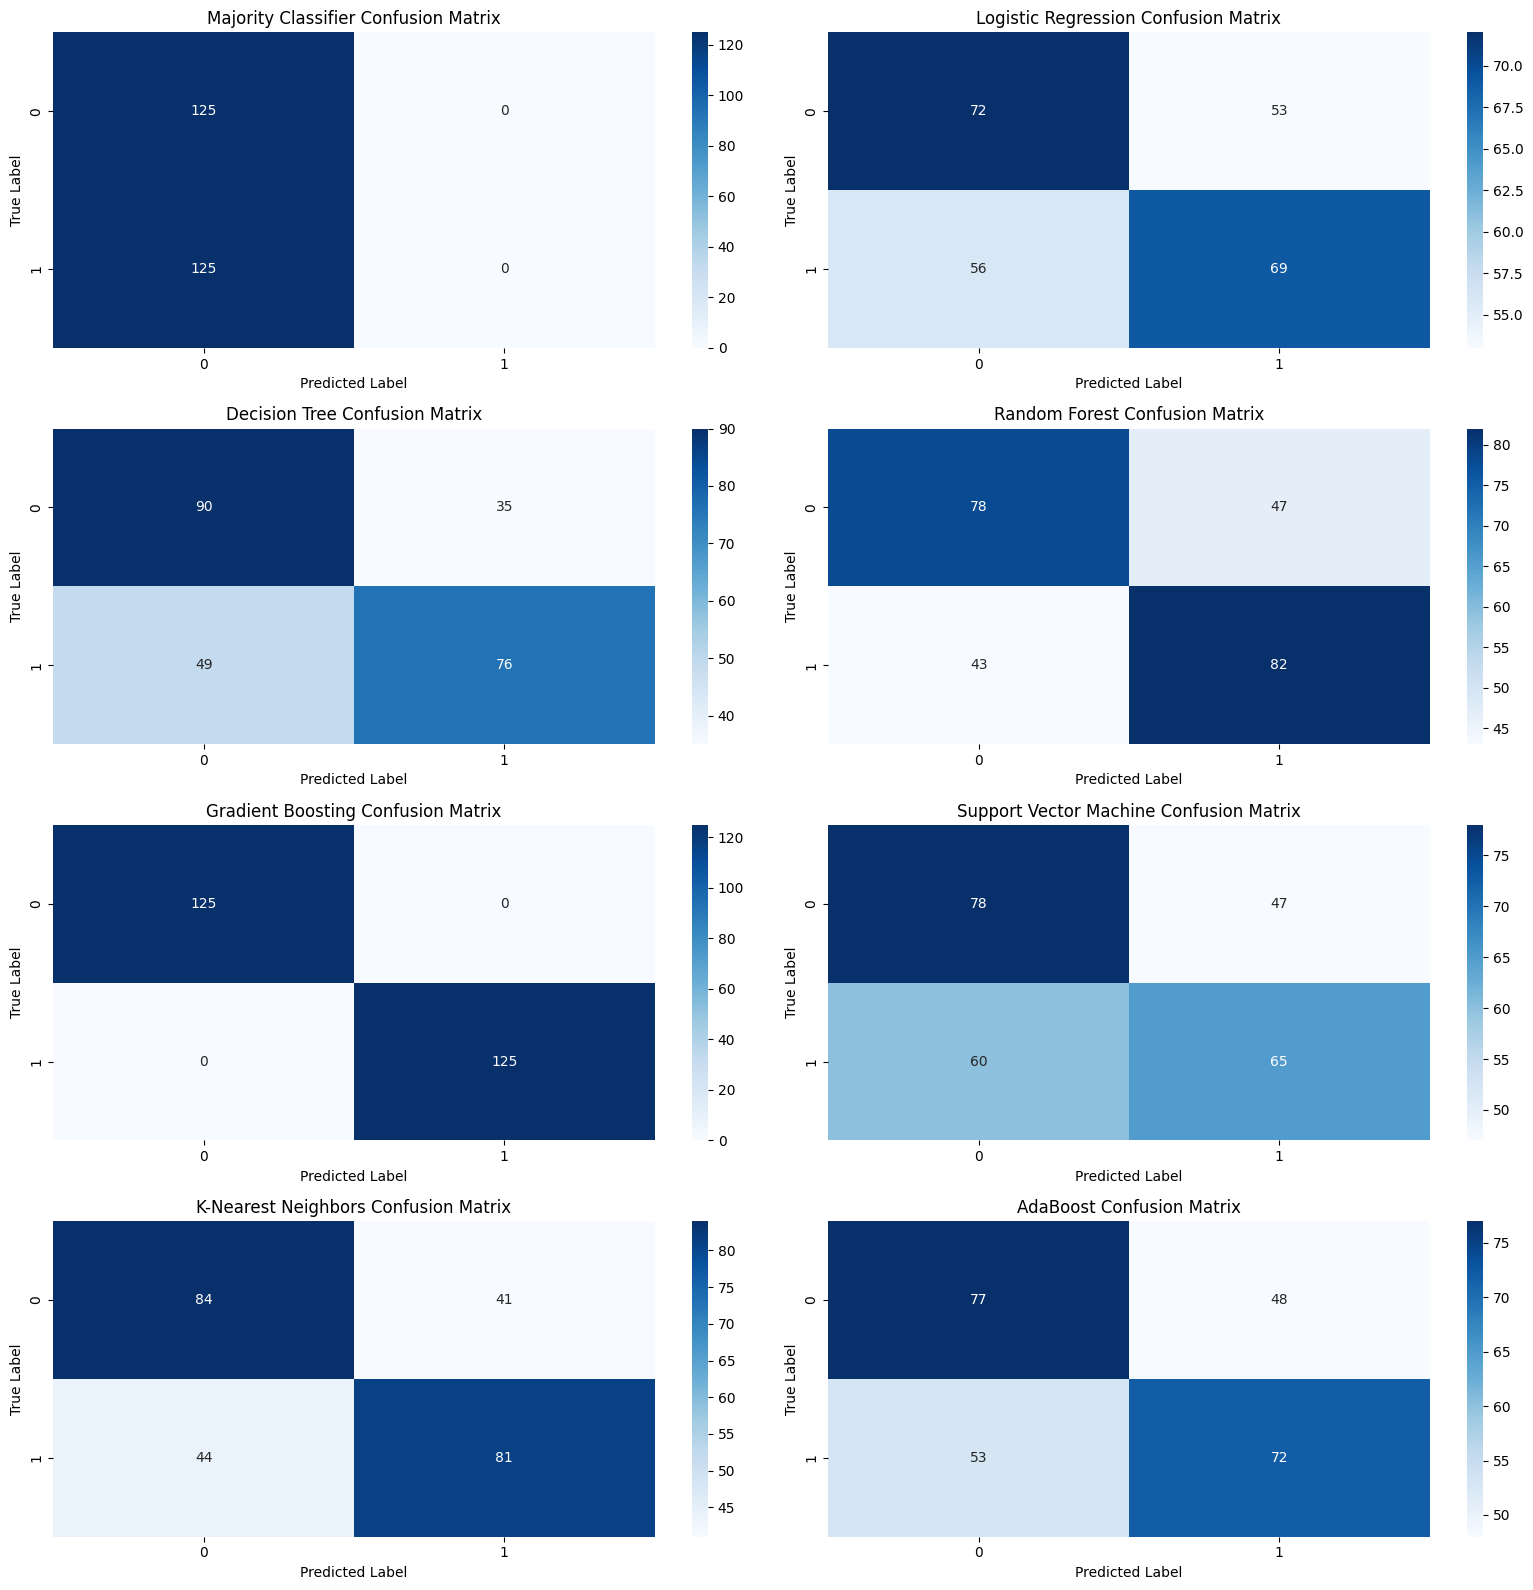

/tmp/ipykernel_45884/2157664961.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted_data['majority_vote'] = predicted_data[['Logistic Regression_result', 'Random Forest_result', 'Support Vector Machine_result']].mode(axis=1)[0]


,commercial_number,BDM,Logistic Regression_result,Random Forest_result,Support Vector Machine_result,majority_vote
0,AD0420,1.0,TP,TP,TP,TP
1,AD0447,1.0,TP,TP,TP,TP
2,AD0581,1.0,TP,TP,TP,TP
3,AD0363,1.0,FN,TP,FN,FN
4,AD0743,1.0,FN,FN,FN,FN
5,AD0677,1.0,FN,TP,FN,FN
6,AD0403,1.0,FN,FN,FN,FN
7,AD0784,1.0,FN,FN,FN,FN
8,AD0679,1.0,FN,FN,FN,FN
9,AD0684,1.0,TP,TP,FN,TP


,commercial_number,BDM,majority_vote,comment
3,AD0363,1.0,FN,
4,AD0743,1.0,FN,
5,AD0677,1.0,FN,
6,AD0403,1.0,FN,
7,AD0784,1.0,FN,
8,AD0679,1.0,FN,
10,AD0386,1.0,FN,
11,AD0620,1.0,FN,
12,AD0628,1.0,FN,
13,AD0428,1.0,FN,


In [657]:
def evaluate_models(X, y, models, cv=5):
    """
    Evaluate models and add predictions to original dataframe
    """
    results = []
    predictions = pd.DataFrame()
    
    for name, model in models.items():
        print(f"Evaluating {name}...")
        model.fit(X, y)
        
        # Get predictions
        y_pred = model.predict(X)
        
        # Create confusion matrix categories
        pred_categories = []
        for true, pred in zip(y, y_pred):
            if true == 0 and pred == 0:
                pred_categories.append('TN')
            elif true == 0 and pred == 1:
                pred_categories.append('FP')
            elif true == 1 and pred == 0:
                pred_categories.append('FN')
            else:  # true == 1 and pred == 1
                pred_categories.append('TP')
        
        predictions[f'{name}_result'] = pred_categories
        
        # Perform cross-validation
        cv_results = cross_validate(
            model, 
            X, 
            y, 
            cv=cv, 
            scoring=['roc_auc', 'accuracy', 'precision', 'recall']
        )
        
        # Calculate metrics as before
        results.append({
            'Model': name,
            'ROC AUC (Mean)': np.mean(cv_results['test_roc_auc']),
            'ROC AUC (Std)': np.std(cv_results['test_roc_auc']),
            'Accuracy (Mean)': np.mean(cv_results['test_accuracy']),
            'Accuracy (Std)': np.std(cv_results['test_accuracy']),
            'Precision (Mean)': np.mean(cv_results['test_precision']),
            'Precision (Std)': np.std(cv_results['test_precision']),
            'Recall (Mean)': np.mean(cv_results['test_recall']),
            'Recall (Std)': np.std(cv_results['test_recall'])
        })
    
    results_df = pd.DataFrame(results).sort_values('ROC AUC (Mean)', ascending=False)
    return results_df, predictions


def plot_confusion_matrices(X, y, models):
    """
    Plot confusion matrices for each model
    
    Parameters:
    - X: Feature matrix
    - y: Target variable
    - models: Dictionary of tuned models
    """
    n_models = len(models)
    fig, axes = plt.subplots(
        nrows=(n_models + 1) // 2, 
        ncols=2, 
        figsize=(16, 4 * ((n_models + 1) // 2))
    )
    axes = axes.ravel()  # Flatten axes array
    
    for i, (name, model) in enumerate(models.items()):
        # Predict using the model
        y_pred = model.predict(X)
        
        # Compute confusion matrix
        cm = confusion_matrix(y, y_pred)
        
        # Plot confusion matrix
        sns.heatmap(
            cm, 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            ax=axes[i]
        )
        axes[i].set_title(f'{name} Confusion Matrix')
        axes[i].set_xlabel('Predicted Label')
        axes[i].set_ylabel('True Label')
    
    # Remove extra subplots if any
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()



results_df, predictions = evaluate_models(data, target, models)
original_data = ad_df_balanced.copy()
original_data = pd.concat([original_data, commercial_numbers], axis=1)

#
# 
#  Add predictions to original data
original_data = pd.concat([original_data, predictions], axis=1)

# Display results
print("Cross-Validation Results:\n")
display(Markdown(results_df.to_markdown(index=False)))
plot_confusion_matrices(data, target, models)

# Display sample of data with predictions


# rename frame
predicted_data = original_data

# only include the top 3 models prediction results
predicted_data = predicted_data[['commercial_number', 'BDM', 'Logistic Regression_result', 'Random Forest_result', 'Support Vector Machine_result']]
# write the majority result of the colums logistic regression, random forest and support vector machine to a new column majority vote
predicted_data['majority_vote'] = predicted_data[['Logistic Regression_result', 'Random Forest_result', 'Support Vector Machine_result']].mode(axis=1)[0]
display(predicted_data.head(10))


linlu_table = predicted_data[['commercial_number', 'BDM', 'majority_vote']]
# only show those rows where the majority vote is FP or FN
linlu_table = linlu_table[(linlu_table['majority_vote'] == 'FP') | (linlu_table['majority_vote'] == 'FN')]
linlu_table['comment'] = ''
display(linlu_table.head(10))

# output to excel
linlu_table.to_excel('linlu_table.xlsx', index=False)


Decision Tree Analysis:


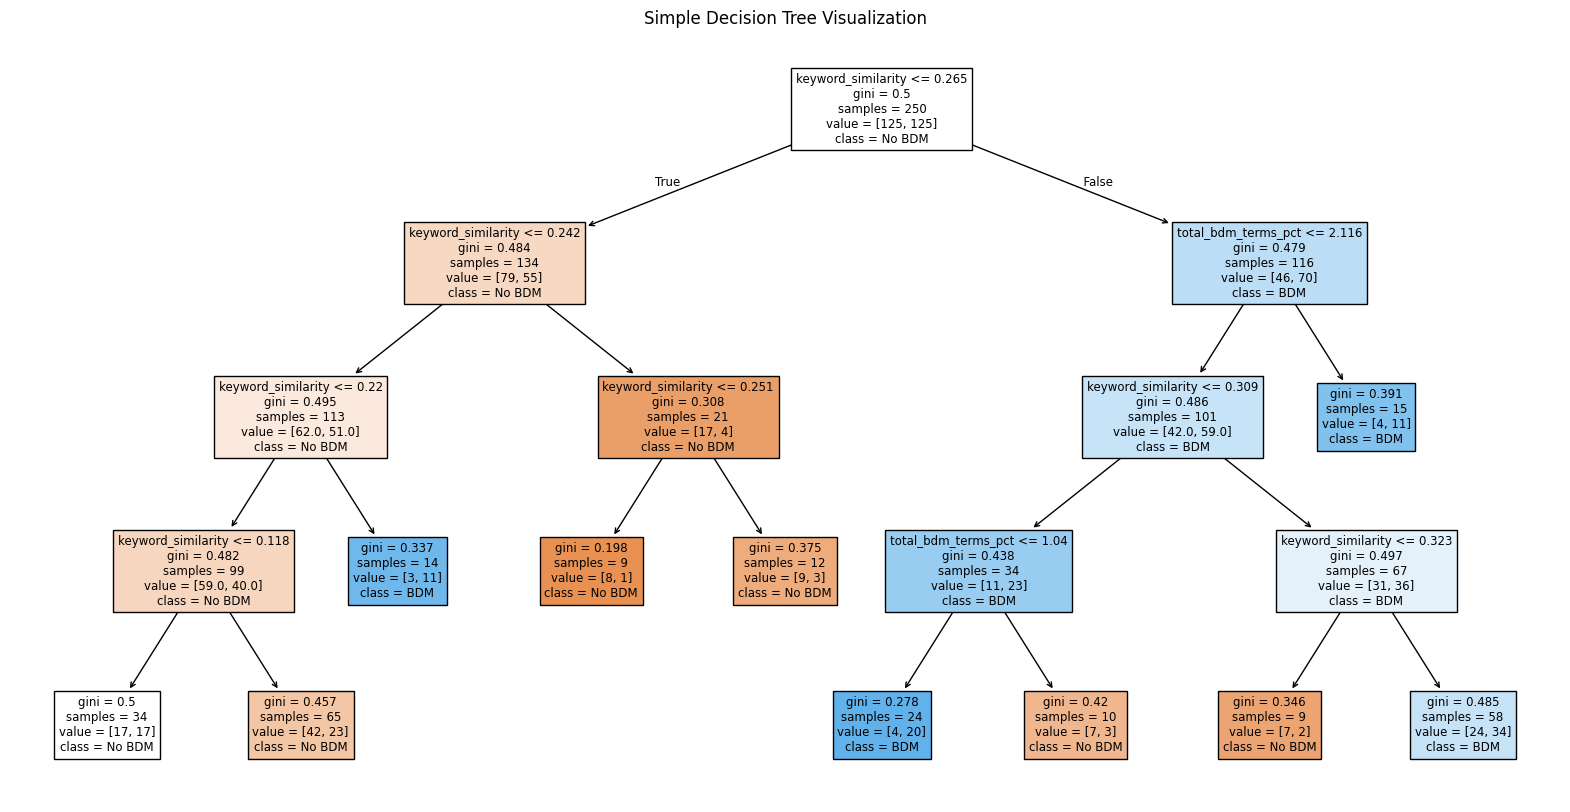


Feature Importance Ranking:
1. keyword_similarity: 0.762
2. total_bdm_terms_pct: 0.238


In [658]:
from sklearn.tree import plot_tree

print("\nDecision Tree Analysis:")
simple_decision_tree = models['Decision Tree']
simple_decision_tree.fit(data, target)

# Create a new figure for the decision tree
plt.figure(figsize=(20, 10))
plot_tree(simple_decision_tree, 
          filled=True, 
          feature_names=data.columns, 
          class_names=['No BDM', 'BDM'])
plt.title("Simple Decision Tree Visualization")
plt.show()

# Print feature importance ranking
importances = simple_decision_tree.feature_importances_
indices = np.argsort(importances)[::-1]

print("\nFeature Importance Ranking:")
for f in range(data.shape[1]):
    print(f"{f + 1}. {data.columns[indices[f]]}: {importances[indices[f]]:.3f}")

## Ansatz 2 - RNN + LSTM

In [659]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

In [660]:
# USING other csv
ad_df = pd.read_csv("ad_df.csv")
ad_df = ad_df[['transcript', 'BDM']]
ad_df = ad_df.rename(columns={"transcript": "description", "BDM": "label"})
ad_df['label'] = ad_df['label'].astype(int)
ad_df.head()

ad_df.info()
df = ad_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465 entries, 0 to 464
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  450 non-null    object
 1   label        465 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 7.4+ KB


In [661]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/Neues_Projekt/venv/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [662]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    df = dataframe.copy()
    labels = df.pop('label')
    
    # Clean the descriptions - replace NaN with empty string and ensure all items are strings
    descriptions = df["description"].fillna("").astype(str).tolist()
    
    # Convert to tensors
    ds = tf.data.Dataset.from_tensor_slices((descriptions, labels))
    
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

In [663]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

# Embedding + Model

In [664]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [665]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(32, 50), dtype=float32, numpy=
array([[ 0.93694675,  0.5016194 , -0.07327973, ..., -0.26254207,
        -0.03780939,  0.51761186],
       [ 0.52414453, -0.03043623, -0.37357947, ..., -0.00565212,
        -0.07582778,  0.63017416],
       [ 0.99284923,  0.5915877 , -0.43612635, ..., -0.43988764,
        -0.12374972,  0.2271776 ],
       ...,
       [ 0.27634883, -0.06144135, -0.41423124, ..., -0.08842818,
        -0.3460005 ,  0.3043015 ],
       [ 0.3719569 ,  0.12941009, -0.24497539, ...,  0.04918613,
         0.3098403 ,  0.27047452],
       [ 1.0060371 ,  0.3370918 ,  0.01940834, ..., -0.20509842,
         0.02248488,  0.5444912 ]], dtype=float32)>

In [666]:
import tf_keras

model = tf_keras.Sequential([
    hub_layer,
    tf_keras.layers.Dense(16, activation='relu'),
    tf_keras.layers.Dropout(0.4),
    tf_keras.layers.Dense(16, activation='relu'),
    tf_keras.layers.Dropout(0.4),
    tf_keras.layers.Dense(1, activation='sigmoid')
])

In [667]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [668]:
model.evaluate(train_data)

12/12 [==============================] - 0s 1ms/step - loss: 0.7709 - accuracy: 0.2742


[0.7708799839019775, 0.27419355511665344]

In [669]:
model.evaluate(valid_data)

2/2 [==============================] - 0s 2ms/step - loss: 0.7512 - accuracy: 0.3043


[0.7512086629867554, 0.30434781312942505]

In [670]:
# history = model.fit(train_data, epochs=3, validation_data=valid_data)

In [671]:
# 


In [672]:
model.evaluate(test_data)

2/2 [==============================] - 0s 6ms/step - loss: 0.7895 - accuracy: 0.1702


[0.7895228862762451, 0.1702127605676651]

# LSTM

In [673]:
encoder = tf.keras.layers.TextVectorization(max_tokens=600)
encoder.adapt(train_data.map(lambda text, label: text))

In [674]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'you', 'to', 'a', 'and', 'i', 'of', 'it', 'we',
       'in', 'is', 'no', 'for', 'on', 'your', 'that', 'this', 'its'],
      dtype='<U12')

In [675]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32, use_cudnn=False),  # Disable cuDNN
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [676]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [677]:
model.evaluate(train_data)
model.evaluate(valid_data)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3224 - loss: 0.6951
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3569 - loss: 0.6950


[0.6951243877410889, 0.3478260934352875]

In [678]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.6547 - loss: 0.6889 - val_accuracy: 0.6957 - val_loss: 0.6718
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.7557 - loss: 0.6533 - val_accuracy: 0.6957 - val_loss: 0.6288
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.7540 - loss: 0.5980 - val_accuracy: 0.6957 - val_loss: 0.6362
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.7386 - loss: 0.5630 - val_accuracy: 0.6957 - val_loss: 0.6271
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.7567 - loss: 0.5478 - val_accuracy: 0.6957 - val_loss: 0.6188


In [679]:
model.evaluate(test_data)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8240 - loss: 0.4925


[0.4876326620578766, 0.8297872543334961]